# Introduction to the Alpine API 2  
## Using workflow variables to visualize the bias - variance tradeoff. 

### Setup:
1.  Upload API_Demo_2.afm into your API Demo workspace.
1.  Open the workflow and configure the data set to point to the location of your dataset in HDFS.
1.  Run the workflow through the Alpine UI to make sure that everything is configured correctly.

### First, we need to repeat some of the setup from demo 1.   Please change the values in the following cell as necessary.


In [1]:
host = "10.10.0.204"
port = "8080"
workflow_id = "320"
username = "demoadmin"
password = "password"

In [2]:
import api as AlpineAPI

from IPython.display import Image
import json
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

### Let's reuse some functions defined in Demo 1.

In [3]:
def find_operator(name, oper_list):
    for oper in oper_list:
        if oper['out_title'] == name:
            return oper
    return []

In [4]:
session = AlpineAPI.Alpine(host, port, username, password)

2017-01-17 22:25:15,356 requests.packages.urllib3.connectionpool connectionpool[214] INFO: Starting new HTTP connection (1): 10.10.0.204


### In this workflow the train set is very small, only 40 observations.  With 10 features, overfitting is a concern.  We have two confusion matricies, one measuring training accuracy and one measuring test accuracy.

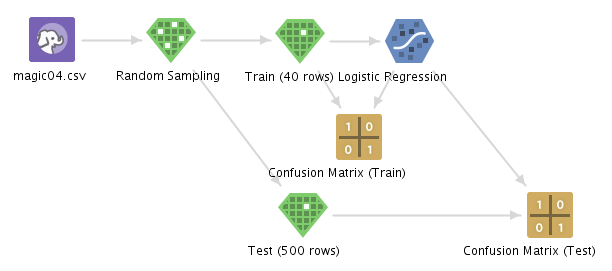

In [5]:
Image(filename='Images/Demo2.png')

### Let's login and run the workflow.

In [6]:
process_id = session.workfile.run_workflow(workflow_id)
session.workfile.wait_for_workflow_to_finish(process_id, verbose=True)

Workflow in progress for ~70 seconds.

'FINISHED'

 ### Finding the test and train accuracies.

In [7]:
workflow_result = session.workfile.download_workflow_results(workflow_id, process_id)

result = json.loads(workflow_result.json())
operator_list = result['outputs']
len(operator_list)
train_COM = find_operator("Confusion Matrix (Train)", operator_list)
test_COM = find_operator("Confusion Matrix (Test)", operator_list)

train_acc = train_COM['visualData'][1]['visualData']['heatMapTable']['accuracy']
test_acc = test_COM['visualData'][1]['visualData']['heatMapTable']['accuracy']

print("Training Accuracy = {0:.1f}%".format(train_acc*100))
print("Testing Accuracy = {0:.1f}%".format(test_acc*100))

2017-01-17 22:30:00,168 requests.packages.urllib3.connectionpool connectionpool[249] INFO: Resetting dropped connection: 10.10.0.204


Training Accuracy = 82.1%
Testing Accuracy = 73.2%


### Since our testing accuracy is much lower than the training accuracy our model is probably overfit.  We'd like to use regularization to improve this.  In the Alpine *Logistic Regression* operator, the strength of regularization is controlled by the *Penalizing Parameter*.  We can use workflow variables to pass in different values of the parameter.  We need to do some setup in the workflow.

 ### Open the workflow.  Double-click the *Logistic Regression* operator and replace the default value of *Penalizing Parameter* with `@lambda`.

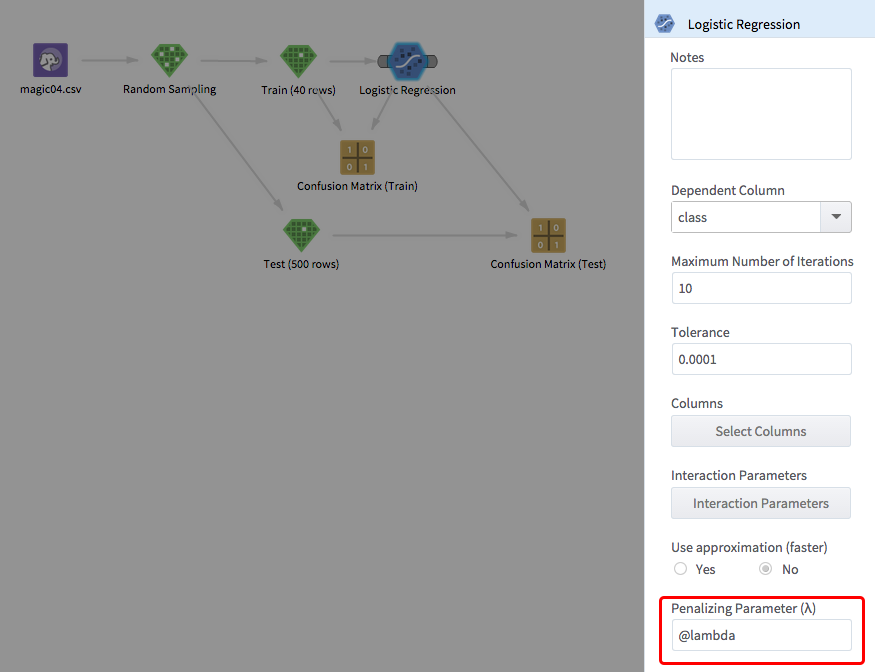

In [8]:
Image(filename='Images/Add_lambda.png')

### In the top right of the browser window, click the *Actions* button and then click *Workflow Variables*.  Create a new variable called `@lambda` and give it a default value of 0.  Save the workflow when you've completed these two steps.

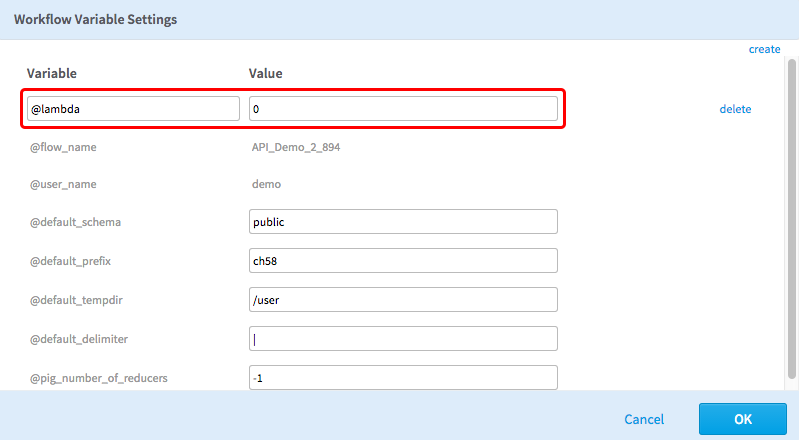

In [9]:
Image(filename='Images/Workflow_variable_settings.png')

### Now we can run the workflow again, except we add the workflow variables as data to our run API function.  Let's choose a value of 0.5 for the parameter.

### We run the workflow and download the result just as before, however we can expect different results for the prediction accuracies.

In [10]:
workflow_variables = [{"name": "@lambda", "value": "0.5"}]
process_id = session.workfile.run_workflow(workflow_id, variables=workflow_variables)
session.workfile.wait_for_workflow_to_finish(process_id, verbose=True)
workflow_result = session.workfile.download_workflow_results(workflow_id, process_id)

Workflow in progress for ~70 seconds.


In [11]:
result = json.loads(workflow_result.json())
operator_list = result['outputs']

train_COM = find_operator("Confusion Matrix (Train)", operator_list)
test_COM = find_operator("Confusion Matrix (Test)", operator_list)

train_acc = train_COM['visualData'][1]['visualData']['heatMapTable']['accuracy']
test_acc = test_COM['visualData'][1]['visualData']['heatMapTable']['accuracy']

print("Training Accuracy = {0:.1f}%".format(train_acc*100))
print("Testing Accuracy = {0:.1f}%".format(test_acc*100))

Training Accuracy = 71.8%
Testing Accuracy = 66.0%


### Low values of the parameter should lead to an overfit model, high values lead to an underfit model, but somewhere in between should be a good model with the proper amount of complexity such that the testing accuracy is maximized.  Let run a loop and test a range of values.  Please change the values in lambda list to test a larger range or a finer grid.  

### The next cell will take a long time to run completely.  For reference, I've included the output in the following cell.

In [12]:
lambda_list = [0, 0.005, 0.01, 0.015, 0.02, 0.0225, 0.025, 0.0275, 0.03, 0.035, 0.04, 0.05, 0.06, 0.08, 0.1]
test_accuracy = [0 for item in lambda_list]
train_accuracy = [0 for item in lambda_list]

print("--------------------------------------------------------")

for index, value in enumerate(lambda_list):
    print("Running workflow with lambda = {}".format(value))
    
    var_dict = {}
    var_dict['name'] = "@lambda"
    var_dict['value'] = str(value)
    workflow_variables = [var_dict]
    
#     workflow_variables=[{"name":"@lambda", "value":"{}"}'.replace("{}", str(value))

    process_id = session.workfile.run_workflow(workflow_id, variables=workflow_variables)
    session.workfile.wait_for_workflow_to_finish(process_id)
    workflow_result = session.workfile.download_workflow_results(workflow_id, process_id)

    result = json.loads(workflow_result.json())
    operator_list = result['outputs']

    train_COM = find_operator("Confusion Matrix (Train)", operator_list)
    test_COM = find_operator("Confusion Matrix (Test)", operator_list)

    train_acc = 100*train_COM['visualData'][1]['visualData']['heatMapTable']['accuracy']
    test_acc = 100*test_COM['visualData'][1]['visualData']['heatMapTable']['accuracy']

    print("Training Accuracy = {0:.1f}%, Testing Accuracy = {1:.1f}%".format(train_acc, test_acc))
    print("--------------------------------------------------------")
    
    test_accuracy[index] = test_acc
    train_accuracy[index] = train_acc

2017-01-17 22:37:47,668 requests.packages.urllib3.connectionpool connectionpool[249] INFO: Resetting dropped connection: 10.10.0.204


--------------------------------------------------------
Running workflow with lambda = 0
Training Accuracy = 82.1%, Testing Accuracy = 73.2%
--------------------------------------------------------
Running workflow with lambda = 0.005
Training Accuracy = 82.1%, Testing Accuracy = 72.8%
--------------------------------------------------------
Running workflow with lambda = 0.01
Training Accuracy = 84.6%, Testing Accuracy = 73.2%
--------------------------------------------------------
Running workflow with lambda = 0.015
Training Accuracy = 82.1%, Testing Accuracy = 74.7%
--------------------------------------------------------
Running workflow with lambda = 0.02
Training Accuracy = 82.1%, Testing Accuracy = 74.7%
--------------------------------------------------------
Running workflow with lambda = 0.0225
Training Accuracy = 79.5%, Testing Accuracy = 75.3%
--------------------------------------------------------
Running workflow with lambda = 0.025
Training Accuracy = 79.5%, Testing 

2017-01-17 22:49:59,105 requests.packages.urllib3.connectionpool connectionpool[249] INFO: Resetting dropped connection: 10.10.0.204


Training Accuracy = 79.5%, Testing Accuracy = 74.5%
--------------------------------------------------------
Running workflow with lambda = 0.04
Training Accuracy = 79.5%, Testing Accuracy = 74.2%
--------------------------------------------------------
Running workflow with lambda = 0.05
Training Accuracy = 79.5%, Testing Accuracy = 74.0%
--------------------------------------------------------
Running workflow with lambda = 0.06
Training Accuracy = 76.9%, Testing Accuracy = 74.0%
--------------------------------------------------------
Running workflow with lambda = 0.08
Training Accuracy = 76.9%, Testing Accuracy = 73.4%
--------------------------------------------------------
Running workflow with lambda = 0.1
Training Accuracy = 74.4%, Testing Accuracy = 72.6%
--------------------------------------------------------


In [13]:
#test_accuracy = [73.01886677742004, 73.58490824699402, 73.58490824699402, 74.52830076217651, 75.28302073478699, 75.09434223175049, 75.47169923782349, 75.47169923782349, 75.09434223175049, 74.71697926521301, 74.33962225914001, 73.77358675003052, 73.96226525306702, 73.20754528045654, 72.26415276527405]
#train_accuracy = [82.05128312110901, 84.61538553237915, 84.61538553237915, 82.05128312110901, 82.05128312110901, 79.48718070983887, 79.48718070983887, 79.48718070983887, 82.05128312110901, 79.48718070983887, 79.48718070983887, 76.92307829856873, 76.92307829856873, 76.92307829856873, 74.35897588729858]
#lambda_list = [0, 0.005, 0.01, 0.015, 0.02, 0.0225, 0.025, 0.0275, 0.03, 0.035, 0.04, 0.05, 0.06, 0.08, 0.1]

### If we plot both prediction accuracies vs. the value of the penalizing parameter, we can see that the test accuracy is maximized near 0.025.

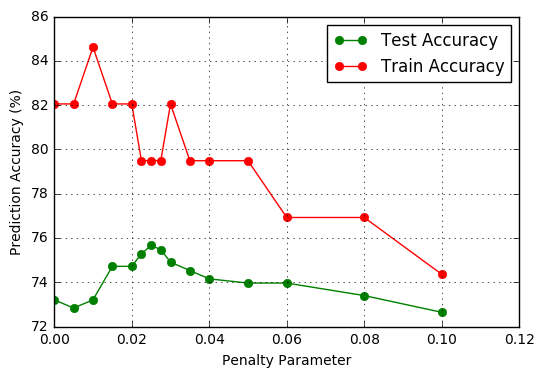

In [14]:
plt.figure(figsize=(6, 4))
plt.plot(lambda_list, test_accuracy, 'g.-', markersize = 12, label="Test Accuracy")
plt.plot(lambda_list, train_accuracy, 'r.-', markersize = 12, label="Train Accuracy")
plt.xlabel("Penalty Parameter")
plt.ylabel("Prediction Accuracy (%)")
plt.grid()
plt.legend()
plt.show()